Using Doccano, I manually annotated 30 'randomly' picked sentences from Indian articles- with labels from this resource: https://towardsdatascience.com/extend-named-entity-recogniser-ner-to-label-new-entities-with-spacy-339ee5979044 

I exported the annoted dataset as admin.jsonl

Converting the json file into a dataframe

In [1]:
import json
import pandas as pd

# loading JSON data from the exported doccano file
json_data_list = []
with open('admin.jsonl', 'r') as file:
    for line in file:
        json_data_list.append(json.loads(line))

sentence_list = []
words_list = []
labels_list = []

for json_data in json_data_list:
    sentence = json_data['text']
    labels = json_data.get('label', [])

    word_list = []
    label_list = []

    for i, word in enumerate(sentence.split()):
        label = 'O'
        for start, end, entity in labels:
            if start <= len(' '.join(sentence.split()[:i + 1])) <= end:
                label = entity
                break

        word_list.append(word)
        label_list.append(label)

    sentence_list.append(sentence)
    words_list.append(word_list)
    labels_list.append(label_list)

df = pd.DataFrame({'sentence': sentence_list, 'words': words_list, 'labels': labels_list})

df.head()


,sentence,words,labels
0,All India Institute of Medical Sciences (AIIMS...,"[All, India, Institute, of, Medical, Sciences,...","[ORG, ORG, ORG, ORG, ORG, ORG, O, O, O, O, O, ..."
1,It is not often that a hockey match ends 4-0 w...,"[It, is, not, often, that, a, hockey, match, e...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,Maharashtra Chief Minister Eknath Shinde on Su...,"[Maharashtra, Chief, Minister, Eknath, Shinde,...","[GPE, O, O, PERSON, PERSON, O, O, O, O, O, O, ..."
3,"If Gujarat looked toothless, Mumbai played the...","[If, Gujarat, looked, toothless,, Mumbai, play...","[O, GPE, O, O, GPE, O, O, O, O, O, O, O, O, O,..."
4,"As per the January 31 order, the RBI asked PPB...","[As, per, the, January, 31, order,, the, RBI, ...","[O, O, O, DATE, DATE, O, O, ORG, O, ORG, O, O,..."


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  32 non-null     object
 1   words     32 non-null     object
 2   labels    32 non-null     object
dtypes: object(3)
memory usage: 900.0+ bytes


In [3]:
df.head()

,sentence,words,labels
0,All India Institute of Medical Sciences (AIIMS...,"[All, India, Institute, of, Medical, Sciences,...","[ORG, ORG, ORG, ORG, ORG, ORG, O, O, O, O, O, ..."
1,It is not often that a hockey match ends 4-0 w...,"[It, is, not, often, that, a, hockey, match, e...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,Maharashtra Chief Minister Eknath Shinde on Su...,"[Maharashtra, Chief, Minister, Eknath, Shinde,...","[GPE, O, O, PERSON, PERSON, O, O, O, O, O, O, ..."
3,"If Gujarat looked toothless, Mumbai played the...","[If, Gujarat, looked, toothless,, Mumbai, play...","[O, GPE, O, O, GPE, O, O, O, O, O, O, O, O, O,..."
4,"As per the January 31 order, the RBI asked PPB...","[As, per, the, January, 31, order,, the, RBI, ...","[O, O, O, DATE, DATE, O, O, ORG, O, ORG, O, O,..."


Similar to Part A, I will run the above NER tagging models on the newly created dataframe. 

In [4]:
sentences = df['sentence']

Using Spacy

In [5]:
import nltk
import spacy
import numpy as np

In [6]:
nlp = spacy.load('en_core_web_sm')
docs = list(nlp.pipe(sentences))

In [7]:
import itertools
nt = df.loc[:,'labels']
ner_true = nt
ner_truemerged2 = list(itertools.chain(*ner_true))

In [8]:
ner_truemerged = []
for i in ner_truemerged2:
    if i != 'O':
        ner_truemerged.append(i)

In [9]:
ner_pred = []
for sentence in sentences:
    doc = nlp(sentence)
    ner_pred.append([ent.label_ for ent in doc.ents])

ner_predmerged = list(itertools.chain(*ner_pred))

In [10]:
print(len(ner_truemerged))
print(len(ner_predmerged))
ner_truemergedctr = pd.Series(ner_truemerged).value_counts().to_dict()
ner_predmergedctr = pd.Series(ner_predmerged).value_counts().to_dict()
print(ner_truemergedctr)
print(ner_predmergedctr)

77
81
{'PERSON': 29, 'ORG': 17, 'GPE': 10, 'WORK_OF_ART': 5, 'MONEY': 4, 'DATE': 3, 'CARDINAL': 3, 'PRODUCT': 2, 'NORP': 2, 'ORDINAL': 2}
{'PERSON': 18, 'DATE': 16, 'GPE': 15, 'ORG': 12, 'CARDINAL': 9, 'NORP': 4, 'PRODUCT': 2, 'WORK_OF_ART': 1, 'TIME': 1, 'LOC': 1, 'ORDINAL': 1, 'EVENT': 1}


No need to reverse map the labels as the labels I annotated with correspond exactly to Spacy's output. The output, however, has matched 1 TIME entity, 1 EVENT entity, and 1 LOC entity which I did not annotate- so including those as 0. 

In [11]:
ner_truemergedctr['TIME'] = 0
ner_truemergedctr['EVENT'] = 0
ner_truemergedctr['LOC'] = 0


In [12]:
#find the difference in value counts in the dictionaries
diff = {}
for key in ner_predmergedctr:
    diff[key] = (ner_truemergedctr[key] - ner_predmergedctr[key])

#find the total
total = 0
for key in diff:
    if key in ner_predmergedctr:
        total += abs(diff[key])
accuracy = 1 - (total/len(ner_truemerged))
accuracy

0.35064935064935066

NLTK


In [13]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Aaryan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Aaryan\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Aaryan\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Aaryan\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [14]:
pos2 = []
tags = []
for sentence in sentences:
    for sent in nltk.sent_tokenize(sentence):
        temp = nltk.pos_tag(nltk.word_tokenize(sent))
        pos2.append(temp)
        for chunk in nltk.ne_chunk(temp):
            
            if hasattr(chunk, 'label'):
                tags.append(chunk.label())

In [15]:
import nltk
from nltk.tokenize import word_tokenize

In [16]:
ner_true_nltk = nt
ner_truemerged_nltk2 = list(itertools.chain(*ner_true_nltk))

In [17]:
ner_truemerged_nltk = []
for i in ner_truemerged_nltk2:
    if i != 'O':
        ner_truemerged_nltk.append(i)

In [18]:
tags

['GPE',
 'ORGANIZATION',
 'ORGANIZATION',
 'GPE',
 'PERSON',
 'GPE',
 'ORGANIZATION',
 'GPE',
 'PERSON',
 'PERSON',
 'PERSON',
 'PERSON',
 'PERSON',
 'PERSON',
 'PERSON',
 'PERSON',
 'ORGANIZATION',
 'ORGANIZATION',
 'ORGANIZATION',
 'ORGANIZATION',
 'GPE',
 'GPE',
 'ORGANIZATION',
 'GPE',
 'GPE',
 'GPE',
 'GPE',
 'PERSON',
 'PERSON',
 'ORGANIZATION',
 'GPE',
 'ORGANIZATION',
 'GPE',
 'ORGANIZATION',
 'ORGANIZATION',
 'PERSON',
 'PERSON',
 'GPE',
 'GPE',
 'PERSON',
 'PERSON',
 'PERSON',
 'GPE',
 'GPE',
 'GPE',
 'PERSON',
 'PERSON',
 'PERSON',
 'GPE',
 'PERSON',
 'PERSON',
 'GPE',
 'PERSON',
 'GPE',
 'ORGANIZATION',
 'PERSON',
 'GPE',
 'GPE',
 'PERSON',
 'ORGANIZATION',
 'PERSON',
 'GPE',
 'GPE',
 'PERSON']

In [19]:
ner_truemergedctr_nltk = pd.Series(ner_truemerged).value_counts().to_dict()
ner_predmergedctr_nltk = pd.Series(tags).value_counts().to_dict()

ner_truemergedctr_nltk['GPE'] = ner_truemergedctr_nltk['GPE'] + ner_truemergedctr_nltk['PRODUCT'] + ner_truemergedctr_nltk['NORP']

del ner_truemergedctr_nltk['PRODUCT']
del ner_truemergedctr_nltk['NORP']

print(ner_truemergedctr_nltk)
print(ner_predmergedctr_nltk)

{'PERSON': 29, 'ORG': 17, 'GPE': 14, 'WORK_OF_ART': 5, 'MONEY': 4, 'DATE': 3, 'CARDINAL': 3, 'ORDINAL': 2}
{'PERSON': 26, 'GPE': 24, 'ORGANIZATION': 14}


In [20]:
ner_predmergedctr_nltk['WORK_OF_ART'] = 0
ner_predmergedctr_nltk['MONEY'] = 0
ner_predmergedctr_nltk['DATE'] = 0
ner_predmergedctr_nltk['CARDINAL'] = 0
ner_predmergedctr_nltk['ORDINAL'] = 0

In [21]:
second_dict = ner_predmergedctr_nltk
reverse_mapping = {
    'PERSON' : 'PERSON',
    'ORGANIZATION': 'ORG',
    'GPE' : 'GPE'
}

converted_dict_nltk = {}


for key, value in second_dict.items():
    new_key = reverse_mapping.get(key)  
    if new_key:  
        converted_dict_nltk[new_key] = value

print(converted_dict_nltk)

{'PERSON': 26, 'GPE': 24, 'ORG': 14}


In [22]:
diff_nltk = {}
total_nltk = 0
for i in ner_truemergedctr_nltk:
    if i in converted_dict_nltk:
        diff_nltk[i] = converted_dict_nltk[i] - ner_truemergedctr_nltk[i]
        total_nltk += abs(diff_nltk[i])

accuracy_nltk = 1 - total_nltk/len(ner_truemerged_nltk)

print(accuracy_nltk)

0.7922077922077921


Stanford

In [23]:
from nltk.tag import StanfordNERTagger

In [24]:
st = StanfordNERTagger(r'C:\Users\Aaryan\Downloads\stanford-ner-4.2.0\stanford-ner-2020-11-17\classifiers\english.muc.7class.distsim.crf.ser.gz',
r'C:\Users\Aaryan\Downloads\stanford-ner-4.2.0\stanford-ner-2020-11-17\stanford-ner.jar',
					   encoding='utf-8')

In [25]:
stanfordner_listoflists = []

for sentence in sentences:
    tokenized_text = word_tokenize(sentence)
    classified_text = st.tag(tokenized_text)
    stanfordner_listoflists.append(classified_text)

stanfordner_list = list(itertools.chain(*stanfordner_listoflists))
stanfordner_list = [elem[1] for elem in stanfordner_list]
stanfordner_list

['O',
 'ORGANIZATION',
 'ORGANIZATION',
 'ORGANIZATION',
 'ORGANIZATION',
 'ORGANIZATION',
 'ORGANIZATION',
 'ORGANIZATION',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'LOCATION',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'PERSON',
 'PERSON',
 'O',
 'O',
 'LOCATION',
 'DATE',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'PERSON',
 'PERSON',
 'O',
 'DATE',
 'O',
 'O',
 'O',
 'O',
 'PERSON',
 'PERSON',
 'PERSON',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'PERSON',
 'PERSON',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'LOCATION',
 'O',
 'O',
 'O',
 'LOCATION',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'DATE',
 'DATE',
 'O',
 'O',
 'O',
 'ORGANIZA

In [26]:
ner_true_stanford = nt
ner_truemerged2_stanford = list(itertools.chain(*ner_true_stanford))

In [27]:
ner_truemergedctr_stanford = pd.Series(ner_truemerged2_stanford).value_counts().to_dict()
ner_predmergedctr_stanford = pd.Series(stanfordner_list).value_counts().to_dict()

print(ner_truemergedctr_stanford)
print(ner_predmergedctr_stanford)

{'O': 544, 'PERSON': 29, 'ORG': 17, 'GPE': 10, 'WORK_OF_ART': 5, 'MONEY': 4, 'DATE': 3, 'CARDINAL': 3, 'PRODUCT': 2, 'NORP': 2, 'ORDINAL': 2}
{'O': 619, 'PERSON': 29, 'ORGANIZATION': 21, 'LOCATION': 18, 'DATE': 13, 'TIME': 1}


{'PERSON': 29, 'ORG': 17, 'GPE': 10, 'WORK_OF_ART': 5, 'MONEY': 4, 'DATE': 3, 'CARDINAL': 3, 'PRODUCT': 2, 'NORP': 2, 'ORDINAL': 2}

{'O': 2026, 'LOCATION': 70, 'PERSON': 67, 'DATE': 42, 'ORGANIZATION': 36, 'MONEY': 15, 'PERCENT': 6}

In [28]:
ner_predmergedctr_stanford['WORK_OF_ART'] = 0
ner_predmergedctr_stanford['CARDINAL'] = 0
ner_predmergedctr_stanford['ORDINAL'] = 0
ner_predmergedctr_stanford['NORP'] = 0
ner_predmergedctr_stanford['PRODUCT'] = 0
ner_truemergedctr_stanford['PERCENT'] = 0

In [29]:
second_dict_stanford = stanfordner_listoflists



reverse_mapping = {
    'LOCATION': 'GPE',
    'O': 'O',
    'ORGANIZATION': 'ORG',
    'PERSON': 'PERSON',
    'DATE': 'DATE',
    'PERCENT': 'CARDINAL',
    'MONEY': 'MONEY'

}

# New dictionary to hold converted values
converted_dict_stanford = {}

# Convert without summing as we're using only B- labels
for key, value in ner_predmergedctr_stanford.items():
    new_key = reverse_mapping.get(key)  # Get the new key from the mapping
    if new_key:  # If the key exists in the mapping
        converted_dict_stanford[new_key] = value

print(converted_dict_stanford)

{'O': 619, 'PERSON': 29, 'ORG': 21, 'GPE': 18, 'DATE': 13}


In [30]:
diff_stanford = {}
total_stanford = 0
for i in ner_truemergedctr_stanford:
    if i in converted_dict_stanford:
        diff_stanford[i] = converted_dict_stanford[i] - ner_truemergedctr_stanford[i]
        total_stanford += abs(diff_stanford[i])

accuracy_stanford = 1 - total_stanford/len(ner_truemerged2_stanford)
accuracy_stanford

0.8438003220611916

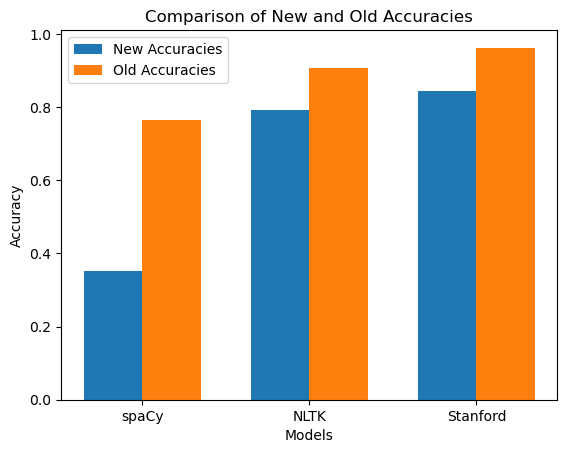

In [31]:
import matplotlib.pyplot as plt

# Assuming you have three accuracy scores
new_accuracy_scores1 = accuracy
new_accuracy_scores2 = accuracy_nltk
new_accuracy_scores3 = accuracy_stanford

old_accuracy1 = 0.7646436418181705
old_accuracy2 = 0.9079106280193237
old_accuracy3 = 0.9620141342756183

models = ['spaCy', 'NLTK', 'Stanford']
new_accuracies = [new_accuracy_scores1, new_accuracy_scores2, new_accuracy_scores3]
old_accuracies = [old_accuracy1, old_accuracy2, old_accuracy3]

bar_width = 0.35
index = range(len(models))

fig, ax = plt.subplots()
bar1 = ax.bar(index, new_accuracies, bar_width, label='New Accuracies')
bar2 = ax.bar([i + bar_width for i in index], old_accuracies, bar_width, label='Old Accuracies')


ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of New and Old Accuracies')
ax.set_xticks([i + bar_width/2 for i in index])
ax.set_xticklabels(models)
ax.legend()


plt.show()

5.
a) Are the levels of performance the same as those recorded earlier? 

No. Let's look at the difference in performances:

The new dataset has a worse performance, although following the same trend model-wise. If we look a little deeper, we see that from the Indian articles the disparity between names, organisations and locations are much worse when it comes to the models.

spaCy for example missed nearly 40% of names by either not recognizing it or, more often, mis-identifying it as a geographic location. Similarly for organisations, hence, the higher geographic location count and far lower persons and organisations count. 

An explanation for this could be that the models have not been trained on data from Indian sources, as the sentences I picked were highly concentrated in Indian names, districts and organisations. 
Like most NLP applications, NER models are predominantly trained on the English language. Hence, the demand for polygot models are significantly on the rise. 

A quick test of the spanish spaCy model can show how most, easy to name entities, are labelled as MISC for miscellaneous.

The efficiency too, forms the same patterns as the original dataset. Spacy is the fastest, followed by nltk and stanfordner